# Deutschland Rent Project - Data Analysis

This notebook will be used to perform a cleaning process in the pre-processed extracted data collected using ```get_offers_infos.py``` and pre-processed using ```offers_infos_preprocessor.py```. 

The goal here is to make the collected data as useble, significant and reliable as possible. I'll porform a first analysis in the formatting and characteristics of the data and remove any possible outlyers, null values, strange characters, transform possible wrong datatypes into the right ones and such.


## Where the data come from.

I got this data from a website that specializes in rental properties in Germany. The data comes in a pre-processed format 

* **offer_id** - unique id for each offer.
* **extraction_date** - extraction datetime.
* **lat** - latitude.
* **lng** - longitude.
* **city** - city.
* **area_m2** - area in squared meters.
* **furnished** - whether is furnished or unfurnished.
* **zip_code** - zip code.
* **main_category** - main category of the property.
* **rooms** - ho many rooms the property have.
* **build_year** - year of construction of the property.
* **state** - state.
* **sub_category** - sub-category of the property. 
* **balcony** - whether is has a balcony or not.
* **heat_type** - which time of head system.
* **offer_title** - the title of the property ad.
* **kitchen** - whether it has a kitchen installed or not.
* **rent_price** - rent price in Euros.
* **garden** - whether it has a garden or not.

## How the data was scraped.

The Python scraper uses the Beautiful Soup package to parsing the HTML website and extract the wanted information from there. As the craper process can be invasive for the website and the main poupose of this project is to leanr and get used to scraper tools, the script is limited to scrape only 11 German cities: Dusseldorf, Berlin, Essen, Munchen, Koln, Stuttgart, Dresden, Hannover, Dortmund, Frankfurt am Main, Hamburg.

## Imports

In [1]:
import re
import plotly
import warnings
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import folium
import geopandas as gpd

from wordcloud import WordCloud
from folium import plugins

## NB configs

In [2]:
warnings.filterwarnings('ignore')

SEED = 43

%matplotlib inline
%pylab inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 18

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.expand_frame_repr', False)

sns.set()

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot

pd.options.display.max_rows = 300
pd.options.display.max_columns = 50
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Populating the interactive namespace from numpy and matplotlib


## Helper functions

In [3]:
# Function to plot values upside the barplot
def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(round(float(p.get_height()),2)), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

def univ_analysis (df, x, y):
    plt.figure(figsize=[20,5])
    plt.subplot(1,3,1)
    sns.boxplot(y=df[x], orient='h')
    plt.subplot(1,3,2)
    sns.histplot(df[x], bins=25)
    plt.title(f'{x} summary:\n', fontsize=16)
    plt.subplot(1,3,3)
    sns.scatterplot(data=df,x=y,y=x)
    plt.savefig(f'../charts/{x}_summary.png');
    
    # quartiles
    q1 = df[x].quantile(0.25)
    q2 = df[x].quantile(0.50)
    q3 = df[x].quantile(0.75)
    q95 = df[x].quantile(0.95)
    irq = q3 - q1
    V_MAX = q3 + (1.5 * irq)
    
    q1_qt = len(df[df[x] <= q1])
    q2_qt = len(df[df[x] <= q2])
    q3_qt = len(df[df[x] <= q3]) 
    q95_qt = len(df[df[x] <= q95]) 
   

    
    

    # outliers
    outliers_perc = ( ( df[df[x] > V_MAX ].count() / len( df ) ) * 100 ).values[0]

    print(f'{x} Analysis:\n')
    print(f' - 1st quartile: {q1:.2f} - Total offers 1st quartile: {q1_qt}')
    print(f' - 2nd quartile: {q2:.2f} - Total offers 2nd quartile: {q2_qt}')
    print(f' - 3rd quartile: {q3:.2f} - Total offers 3rd quartile: {q3_qt}')
    print(f' - 95th percentile: {q95:.2f} - Total offers 95th percentile: {q95_qt}')
    print(f' - Possible outliers: {outliers_perc:.2f}%\n')
    print(f' - Standart deviation: {round(df[x].std(),2)}')
    print(f' - Variance od the data: {round(np.var(df[x]),2)}\n\n')
    
    
    return None

## Load Data

In [4]:
df = pd.read_csv('../data/all_offers_cleaned.csv')

In [5]:
df.head(2)

,offer_id,extraction_date,lat,lng,city,area_m2,zip_code,main_category,rooms,build_year,state,sub_category,balcony,heat_type,offer_title,kitchen,rent_price,garden
0,45678593,2021-11-17 22:34:03,50.10168,8.65827,Dusseldorf,65.00000,60327.00000,Wohnung,3.00000,1903.00000,Hessen,Etagenwohnung,0,Zentralheizung,* frisch renovierte 3 Zimmerwohnung * Innensta...,0,790.00000,0
1,45907970,2021-11-17 22:34:03,50.92959,6.95620,Dusseldorf,40.00000,50674.00000,Wohnung,1.00000,1994.00000,Nordrhein-Westfalen,Apartment,1,Etagenheizung,Apartment Wohnung voll möbliert inder Zentral...,1,600.00000,0


In [6]:
df.shape

(6046, 18)

## Summarizing the Dataset

In [7]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[0]}\n')
print(f'Number of offers by city:\n')

df_aux = pd.DataFrame(df.groupby('city')['offer_id'].count().reset_index())
for x in range(len(df_aux)):
    print(f"{df_aux.iloc[x]['city']}: {df_aux.iloc[x]['offer_id']}")

Number of rows: 6046
Number of columns: 6046

Number of offers by city:

Berlin: 460
Dortmund: 249
Dresden: 1298
Dusseldorf: 363
Essen: 331
Frankfurt am Main: 710
Hamburg: 1187
Hannover: 207
Koln: 142
Munchen: 753
Stuttgart: 346


In [8]:
num_att = df.select_dtypes(include=['int64', 'float64'])
cat_att = df.select_dtypes(exclude=['int64', 'float64'])

#count = pd.DataFrame(num_att.apply(lambda x: x.count)).T

# location
mean = pd.DataFrame(num_att.apply(np.mean)).T
median = pd.DataFrame(num_att.apply(np.median)).T
min_ = pd.DataFrame(num_att.apply(np.min)).T
max_ = pd.DataFrame(num_att.apply(np.max)).T

# Variability
std = pd.DataFrame(num_att.apply(np.std)).T
range_ = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T

# Skewness
skness = pd.DataFrame(num_att.apply(lambda x: x.skew())).T

# Kurtosis.
kurt = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# cancat
descriptive = pd.concat([min_, max_, range_, mean, median, std, skness, kurt]).T.reset_index()
descriptive.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis']
descriptive

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,offer_id,946633.00000,45938205.00000,44991572.00000,45365424.43004,45806074.50000,1939680.44147,-12.82267,216.21173
1,lat,6.96404,53.81402,46.84998,51.11477,51.06520,1.95825,-5.68534,122.76776
2,lng,6.31252,51.50788,45.19536,10.57136,10.01623,2.60062,1.93675,28.75078
3,area_m2,15.00000,400.00000,385.00000,68.97253,63.01000,33.85015,2.04937,8.77325
4,zip_code,1067.00000,85640.00000,84573.00000,35290.87146,NaN,27614.31450,0.28791,-1.23497
5,rooms,1.00000,11.00000,10.00000,2.28184,2.00000,0.97689,0.96189,2.65717
6,build_year,1740.00000,2021.00000,281.00000,1978.86894,NaN,40.99935,-0.78613,-0.16287
7,balcony,0.00000,1.00000,1.00000,0.41929,0.00000,0.49344,0.32723,-1.89355
8,kitchen,0.00000,1.00000,1.00000,0.50645,1.00000,0.49996,-0.02581,-2.00000
9,rent_price,200.00000,8600.00000,8400.00000,1023.41846,850.00000,719.65893,3.08872,17.76037


## Feature Engineering

In [9]:
# Price x m2
df['price_m2'] = df['rent_price'] / df['area_m2']

In [10]:
df.columns

Index(['offer_id', 'extraction_date', 'lat', 'lng', 'city', 'area_m2',
       'zip_code', 'main_category', 'rooms', 'build_year', 'state',
       'sub_category', 'balcony', 'heat_type', 'offer_title', 'kitchen',
       'rent_price', 'garden', 'price_m2'],
      dtype='object')

In [11]:
# reorder the columns
df = df[[ 'extraction_date', 'offer_id', 'city', 'state', 'zip_code', 'lat', 'lng',
         'main_category', 'sub_category', 'offer_title', 'rent_price', 'area_m2', 
         'price_m2', 'rooms', 'balcony', 'kitchen', 'garden',  'build_year',
         'heat_type']]

In [12]:
df.head(2)

,extraction_date,offer_id,city,state,zip_code,lat,lng,main_category,sub_category,offer_title,rent_price,area_m2,price_m2,rooms,balcony,kitchen,garden,build_year,heat_type
0,2021-11-17 22:34:03,45678593,Dusseldorf,Hessen,60327.00000,50.10168,8.65827,Wohnung,Etagenwohnung,* frisch renovierte 3 Zimmerwohnung * Innensta...,790.00000,65.00000,12.15385,3.00000,0,0,0,1903.00000,Zentralheizung
1,2021-11-17 22:34:03,45907970,Dusseldorf,Nordrhein-Westfalen,50674.00000,50.92959,6.95620,Wohnung,Apartment,Apartment Wohnung voll möbliert inder Zentral...,600.00000,40.00000,15.00000,1.00000,1,1,0,1994.00000,Etagenheizung


## Exploratory Data Analysis


    Each row in our dataset representes a property rent offer. The offers are divided in two main categies: Wohnung (appartment) and Haus (house) and the columns represents the characteristics for each property.
    
    The goal here is to look for and find relevant information, patterns and try to get meaningful insights from the data.


In [13]:
df2 = df.copy()

### Plan

#### Checklist

- Check the rent price distributions.
- Check average rent price for each city.
- Check price/m2 for each city.
- Check price/m2 for each zip code.
- Check average price per years build.
- Check average price by state.
- Check average price by room.
- Check average price by sub-category.
- Check average price by heat type.
- Check the title to more common words.

#### Main Hypothesis

1. Offers with larger areas are more expensive.
2. The more rooms, the more expensive.
3. Offers with garten are more expensive.
4. Offers with pre-installed kitchens are more expensive.
5. Offers in old buildings are less expensive.
6. Offers with balcony are more expensive.

### RENT PRICE

#### How the offers rent price is distributed?

rent_price Analysis:

 - 1st quartile: 550.00 - Total offers 1st quartile: 1564
 - 2nd quartile: 850.00 - Total offers 2nd quartile: 3081
 - 3rd quartile: 1295.00 - Total offers 3rd quartile: 4538
 - 95th percentile: 2200.00 - Total offers 95th percentile: 5745
 - Possible outliers: 3.79%

 - Standart deviation: 719.72
 - Variance od the data: 517908.97




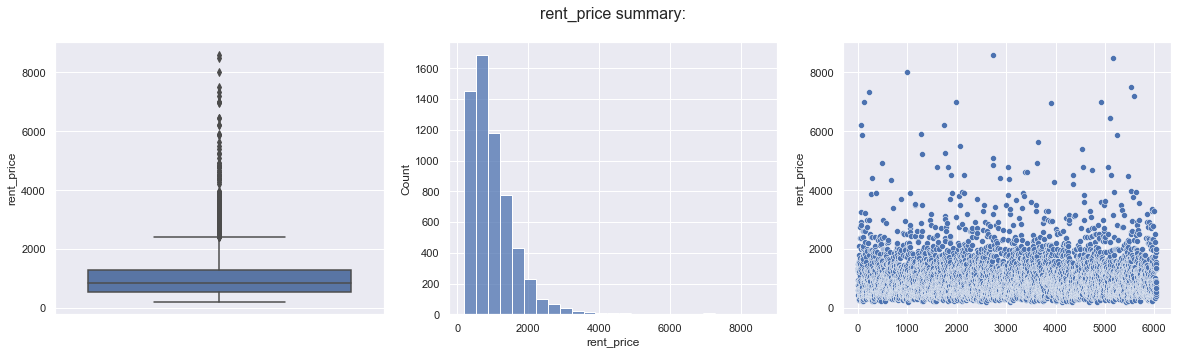

In [14]:
univ_analysis(df=df2, x='rent_price', y=df2.index)

 - In this summary plot we can see that the rent prices are very skwed to left, lower values, and 95% of the rent prices are under 2200€.

#### How the rent price is distributes if we set ranges for the areas?

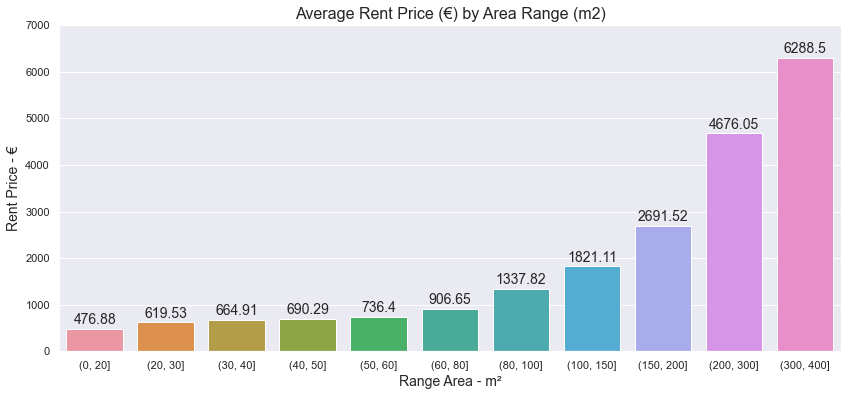

In [105]:
# create a auxiliar dataframe to aggregate the needed infos
df_aux = df2[['area_m2', 'rent_price', 'price_m2']]
df_aux['range_area'] = pd.cut(df_aux['area_m2'], [0, 20, 30, 40, 50, 60, 80, 100, 150, 200, 300, 400])
df_aux2 = pd.DataFrame(df_aux.groupby('range_area')['rent_price', 'price_m2'].mean().round(2)).reset_index()

# plot the infos
ax = sns.barplot(x=df_aux2['range_area'], y=df_aux2['rent_price'])
ax.set_title('Average Rent Price (€) by Area Range (m2)', fontsize=16)
ax.set_ylabel('Rent Price - €', fontsize=14)
ax.set_xlabel('Range Area - m²', fontsize=14)
ax.set(ylim=(0, 7000))
annot_plot(ax)
plt.savefig('../charts/avg_rent_by_m2.png')

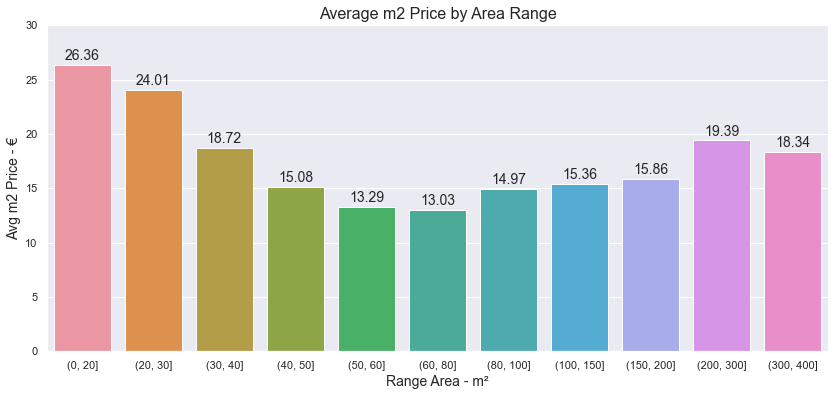

In [109]:
# plot the infos
ax = sns.barplot(x=df_aux2['range_area'], y=df_aux2['price_m2'])
ax.set_title('Average m2 Price by Area Range', fontsize=16)
ax.set_ylabel('Avg m2 Price - €', fontsize=14)
ax.set_xlabel('Range Area - m²', fontsize=14)
ax.set(ylim=(0, 30))
annot_plot(ax)
plt.savefig('../charts/avg_m2_by_range_area.png')

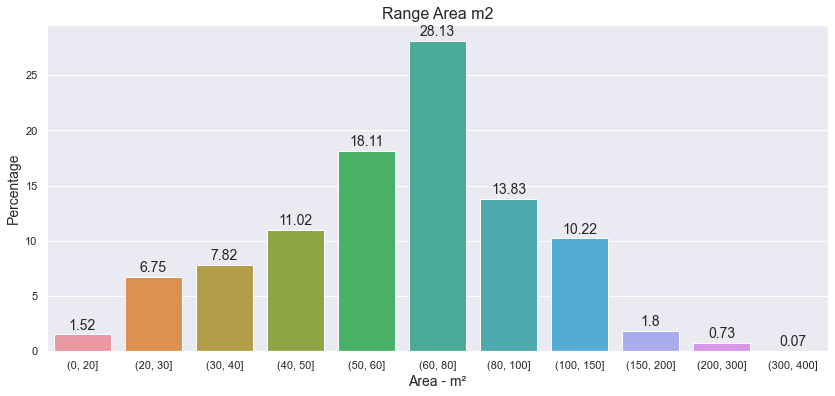

In [16]:
df_aux2 = pd.DataFrame(df_aux['range_area'].value_counts(normalize=True) * 100).reset_index().sort_values(by='index')
ax = sns.barplot(df_aux2['index'], df_aux2['range_area'])
ax.set_title('Range Area m2', fontsize=16)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_xlabel('Area - m²', fontsize=14)
annot_plot(ax)
plt.savefig('../charts/histogram_range_area.png')

 - Here we can see that more than 28% of the propertyes have between 60m2 and 80m2 and the area distribution follows a normal distribution.

|    | index      |   range_area |
|---:|:-----------|-------------:|
|  0 | (0, 20]    |    1.52167   |
|  1 | (20, 30]   |    6.74826   |
|  2 | (30, 40]   |    7.82335   |
|  3 | (40, 50]   |   11.0155    |
|  4 | (50, 60]   |   18.1111    |
|  5 | (60, 80]   |   28.1343    |
|  6 | (80, 100]  |   13.8273    |
|  7 | (100, 150] |   10.2216    |
|  8 | (150, 200] |    1.80284   |
|  9 | (200, 300] |    0.727754  |
| 10 | (300, 400] |    0.0661594 |

#### What is the distribution of the rent price among the cities?

In [17]:
# STATISTIC DESCRIPTION
desc_city_rent_price = df2.groupby('city').describe()['rent_price'].reset_index()
desc_city_rent_price['sum'] = df2.groupby('city')['rent_price'].sum().reset_index()['rent_price']
desc_city_rent_price

,city,count,mean,std,min,25%,50%,75%,max,sum
0,Berlin,460.00000,987.90217,595.65787,214.00000,550.00000,842.50000,1300.00000,4930.00000,454435.00000
1,Dortmund,249.00000,964.27711,659.77355,200.00000,575.00000,850.00000,1140.00000,6950.00000,240105.00000
2,Dresden,1298.00000,1015.98305,703.56399,210.00000,550.25000,848.00000,1293.25000,8600.00000,1318746.00000
3,Dusseldorf,363.00000,1063.95868,887.87559,229.00000,489.50000,850.00000,1329.00000,7350.00000,386217.00000
4,Essen,331.00000,980.91843,694.71265,212.00000,537.50000,800.00000,1217.50000,8000.00000,324684.00000
5,Frankfurt am Main,710.00000,1022.67465,667.52887,200.00000,550.00000,850.00000,1294.75000,5390.00000,726099.00000
6,Hamburg,1187.00000,1047.26201,790.96089,213.00000,550.00000,849.00000,1298.50000,8500.00000,1243100.00000
7,Hannover,207.00000,1133.81643,646.03757,247.00000,639.50000,975.00000,1431.50000,3290.00000,234700.00000
8,Koln,142.00000,1003.45775,764.78813,220.00000,542.50000,797.50000,1349.50000,7000.00000,142491.00000
9,Munchen,753.00000,1022.34130,710.22828,216.00000,550.00000,840.00000,1298.00000,6200.00000,769823.00000


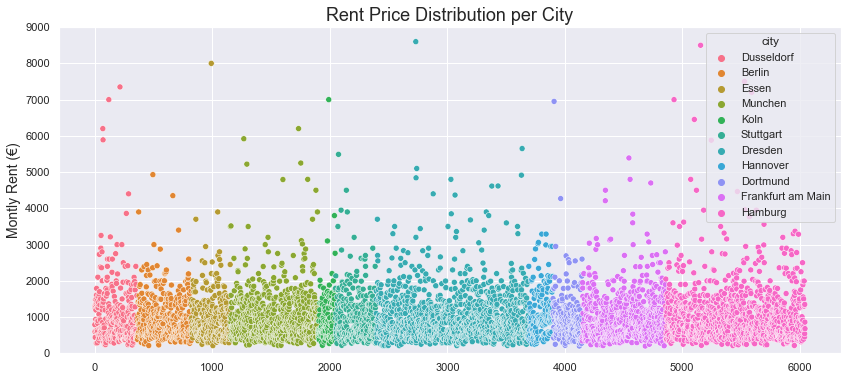

In [18]:
# scatterplot - all offers - Offer rent price by city

ax = sns.scatterplot(x = df2.index, y = 'rent_price', hue = 'city', data = df2)
plt.title('Rent Price Distribution per City', fontsize = 18)
plt.ylabel('Montly Rent (€)', fontsize = 14)
ax.set(ylim=(0, 9000))
ax.figure.savefig(r'../images/rent_distribution_by_city.png')

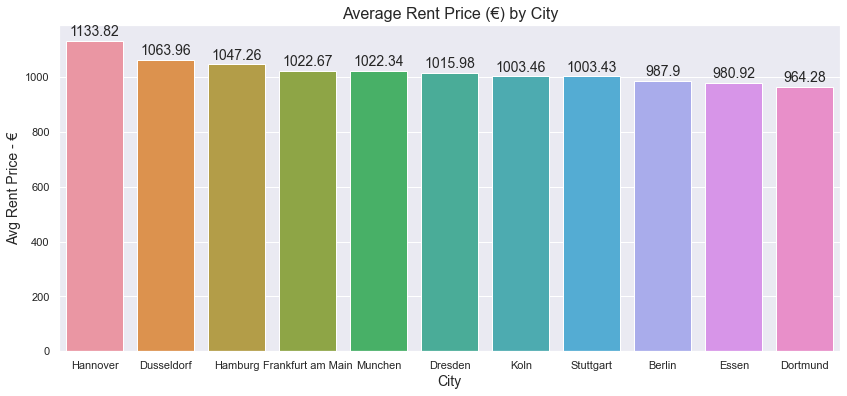

In [19]:
# Average rent price by city
df_aux = pd.DataFrame(df2.groupby('city')['rent_price'].mean()).reset_index().sort_values(by='rent_price', ascending=False)

# plot the infos
ax = sns.barplot(x=df_aux['city'], y=df_aux['rent_price'])
ax.set_title('Average Rent Price (€) by City', fontsize=16)
ax.set_ylabel('Avg Rent Price - €', fontsize=14)
ax.set_xlabel('City', fontsize=14)
annot_plot(ax)
plt.savefig('../charts/avg_rent_by_city.png')

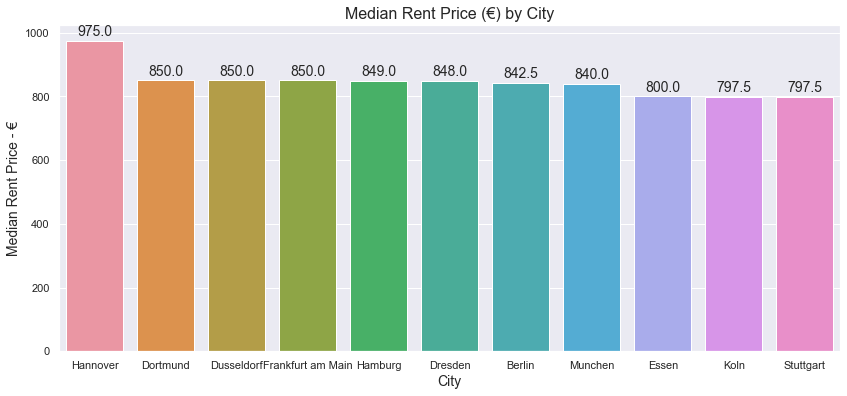

In [20]:
# Average rent price by city
df_aux = pd.DataFrame(df2.groupby('city')['rent_price'].median()).reset_index().sort_values(by='rent_price', ascending=False)

# plot the infos
ax = sns.barplot(x=df_aux['city'], y=df_aux['rent_price'])
ax.set_title('Median Rent Price (€) by City', fontsize=16)
ax.set_ylabel('Median Rent Price - €', fontsize=14)
ax.set_xlabel('City', fontsize=14)
annot_plot(ax)
plt.savefig('../charts/median_rent_by_city.png')

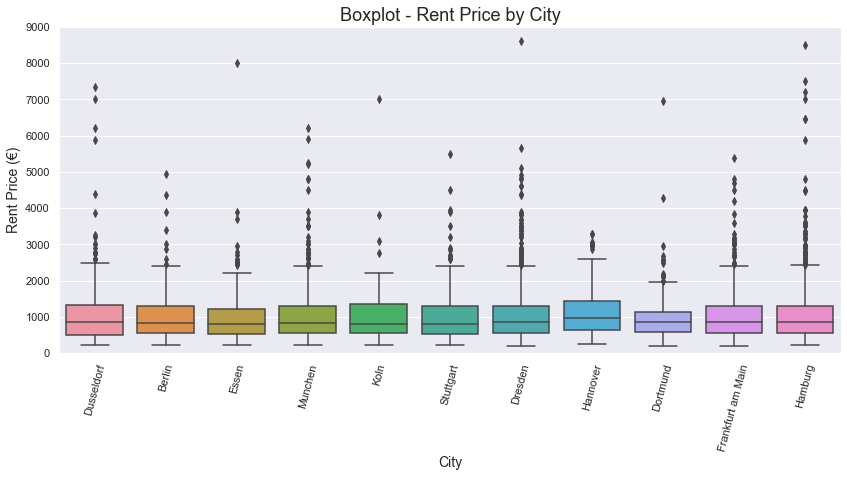

In [21]:
# boxrplot - all offers - Offer rent price by city

ax = sns.boxplot(x = 'city', y = 'rent_price', data = df2)
plt.title('Boxplot - Rent Price by City', fontsize = 18)
plt.ylabel('Rent Price (€)', fontsize = 14)
plt.xlabel('City', fontsize = 14)
plt.xticks(rotation=75)
ax.set(ylim=(0, 9000));
ax.figure.savefig(r'../images/boxplot_rent_by_city.png')

 - The average rent price by city are not that too different, with a variation between 1135€ and 965€ where Hannover is the most expensive and Dortmund the cheapest city.

#### What is the price distribution by state?

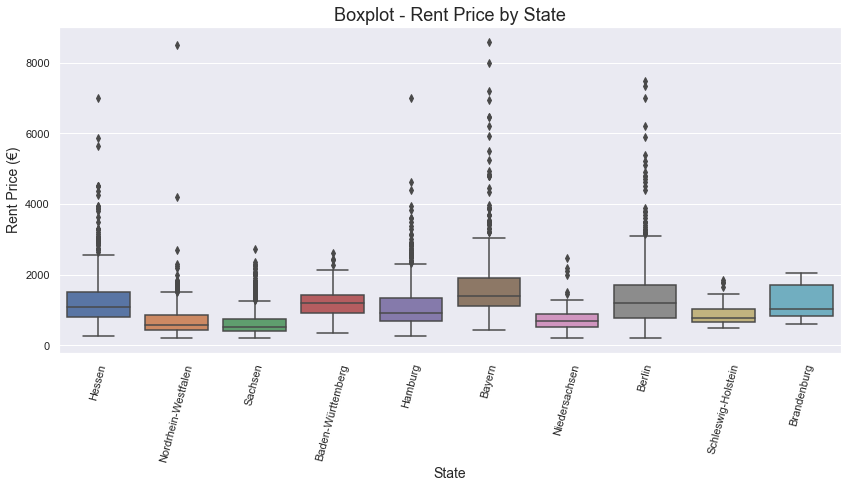

In [22]:
# boxrplot - all offers - Offer rent price by state

ax = sns.boxplot(x = 'state', y = 'rent_price', data = df2)
plt.title('Boxplot - Rent Price by State', fontsize = 18)
plt.ylabel('Rent Price (€)', fontsize = 14)
plt.xlabel('State', fontsize = 14)
plt.xticks(rotation=75);
ax.figure.savefig(r'../images/boxplot_rent_by_state.png')

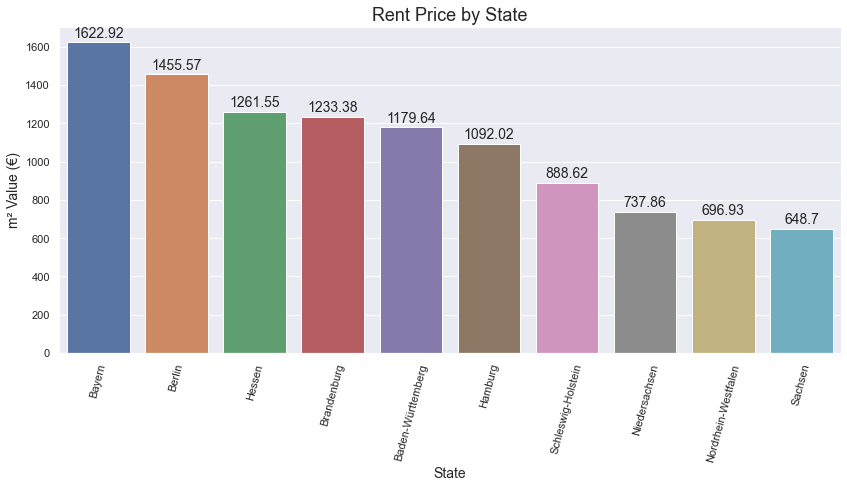

In [23]:
# Average rent price by state

df_aux = pd.DataFrame(df2.groupby('state')['rent_price'].mean()).reset_index().sort_values(by='rent_price', ascending=False)
# plot the infos
ax = sns.barplot(x=df_aux['state'], y=df_aux['rent_price'])
plt.title('Rent Price by State', fontsize = 18)
plt.ylabel('m² Value (€)', fontsize = 14)
plt.xlabel('State', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax)
plt.savefig('../charts/avg_rent_by_state.png')

- This is mainly due to the number of samples and some outliers. We will see how the data behave by excluding the maximum and minimum values for each state.

- Excluding max and min rent prices values does not change much the average rent prices by state. 

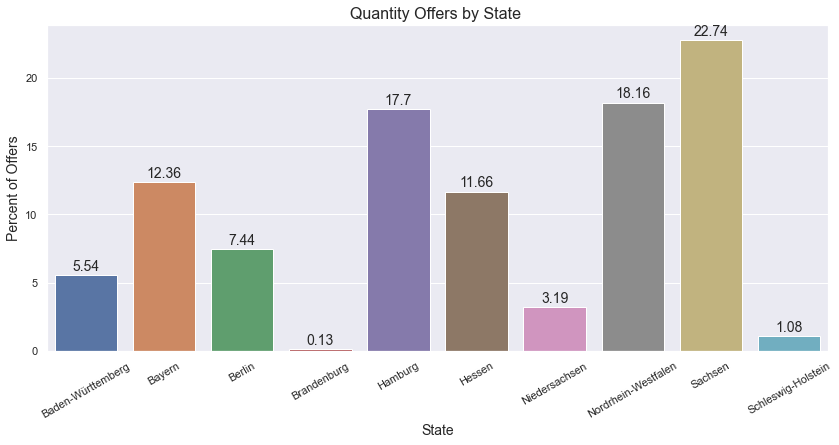

In [28]:
# Quantity offers by state - %

df_aux = pd.DataFrame(df2.groupby('state')['offer_id'].count()).reset_index()
df_aux['offer_id'] = (df_aux['offer_id'] / df_aux['offer_id'].sum()) * 100
ax = sns.barplot(x=df_aux['state'], y=df_aux['offer_id'])
ax.set_title('Quantity Offers by State ', fontsize=16)
ax.set_ylabel('Percent of Offers', fontsize=14)
ax.set_xlabel('State', fontsize=14)
plt.xticks(rotation=30)
annot_plot(ax)
plt.savefig('../charts/offers_by_state.png')

<AxesSubplot:title={'center':'Boxplot - Bayern Rent Price Distribution'}>

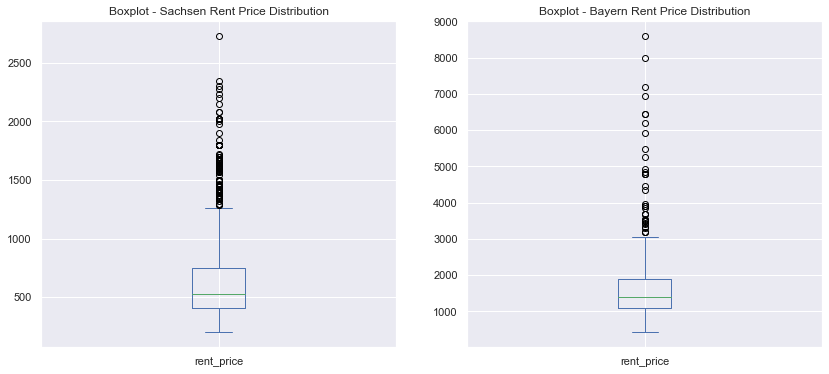

In [29]:
df_aux = df2[df2['state'] == 'Sachsen']
df_aux2 = df2[df2['state'] == 'Bayern']
plt.subplot(1,2,1)
df_aux['rent_price'].plot(kind='box', title='Boxplot - Sachsen Rent Price Distribution', grid=True)
plt.subplot(1,2,2)
df_aux2['rent_price'].plot(kind='box', title='Boxplot - Bayern Rent Price Distribution', grid=True)

 - Here we can se a huge difference of prices between the states, being Beyern the most expensive state, with a average rent price of 1620€ and Sachsen the cheapest, with the average rent price of 650€. At first I thought that this huege difference could be due to the number off offers in each state, but Byern is the 4th state with more offers, 12,3% and Sachsen represents almost 23% of the dataset, but the boxplots shows us that some more expensive offers in Bayern pull the average up.
  


### m² PRICE - Which are the most cheaper end most expesive m2 price in Germany?

price_m2 Analysis:

 - 1st quartile: 9.70 - Total offers 1st quartile: 1512
 - 2nd quartile: 13.48 - Total offers 2nd quartile: 3024
 - 3rd quartile: 18.99 - Total offers 3rd quartile: 4534
 - 95th percentile: 29.66 - Total offers 95th percentile: 5743
 - Possible outliers: 2.84%

 - Standart deviation: 7.5
 - Variance od the data: 56.29




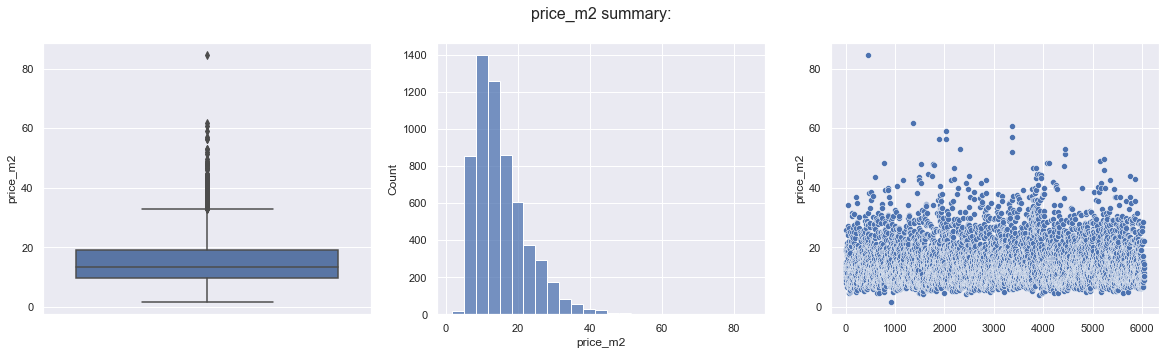

In [30]:
univ_analysis(df=df2, x='price_m2', y=df2.index)

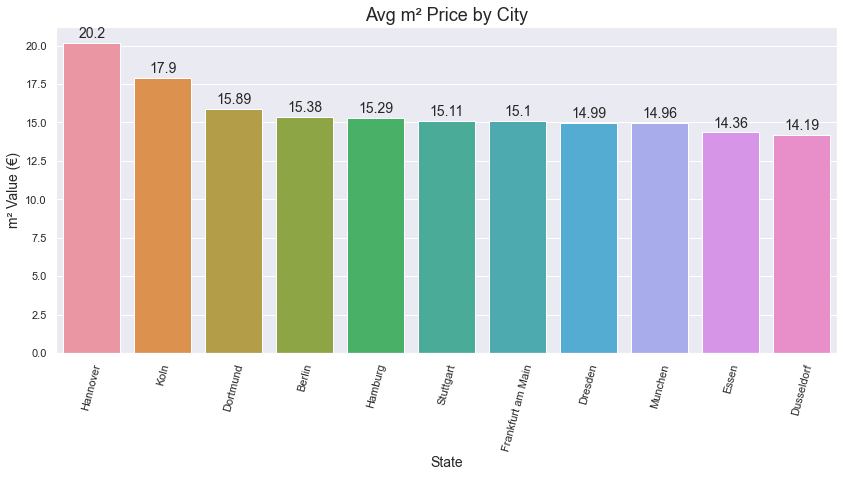

In [31]:
# m2 price by city
df_aux_m2_city = pd.DataFrame(df2.groupby('city')['price_m2'].mean()).reset_index().sort_values(by='price_m2', ascending=False)

ax = sns.barplot(x = 'city', y = 'price_m2', data = df_aux_m2_city)
plt.title('Avg m² Price by City', fontsize = 18)
plt.ylabel('m² Value (€)', fontsize = 14)
plt.xlabel('State', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax);
ax.figure.savefig(r'../images/barplot_m²_price_by_city.png')

- Düsseldorf has the cheapest average m2 price of all Germany and Hannover has the most expesive m2 price.

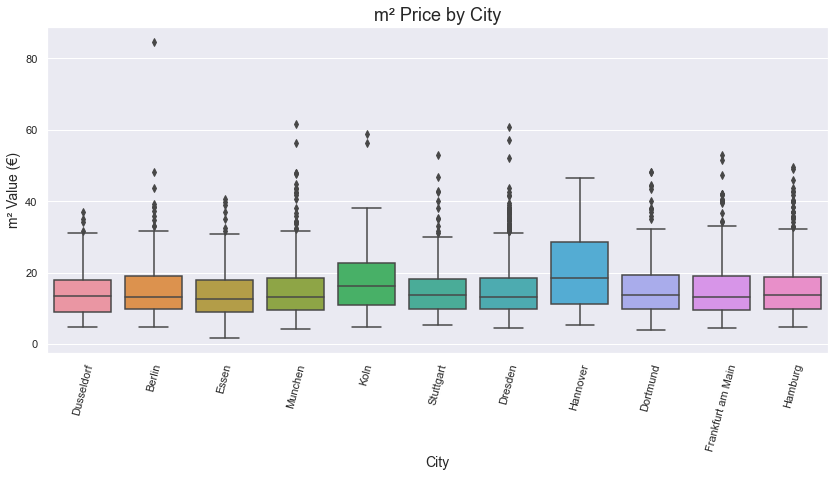

In [32]:
# m2 price by city

ax = sns.boxplot(x = 'city', y = 'price_m2', data = df2)
plt.title('m² Price by City', fontsize = 18)
plt.ylabel('m² Value (€)', fontsize = 14)
plt.xlabel('City', fontsize = 14)
plt.xticks(rotation=75);
ax.figure.savefig(r'../images/boxplot_m²_price_by_city.png')

- Here we have a big "outlier" in Berlin, a place with about 84€ per m2. As these are prices and we do not know the localization and conditions of the rent offer, we assume that it is correct.

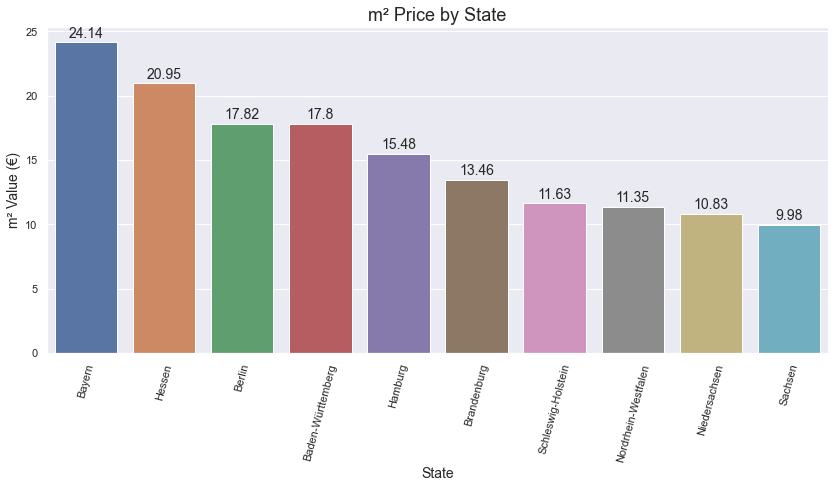

In [33]:
df_aux = pd.DataFrame(df2.groupby('state')['price_m2'].mean()).reset_index().sort_values(by='price_m2', ascending=False)
# plot the infos
ax = sns.barplot(x=df_aux['state'], y=df_aux['price_m2'])
plt.title('m² Price by State', fontsize = 18)
plt.ylabel('m² Value (€)', fontsize = 14)
plt.xlabel('State', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax)
plt.savefig('../charts/avg_price_m2_by_state.png')

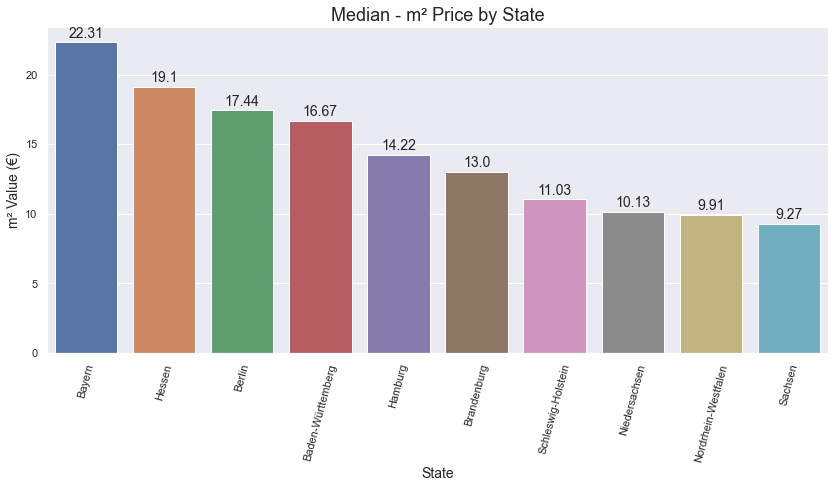

In [34]:
df_aux = pd.DataFrame(df2.groupby('state')['price_m2'].median()).reset_index().sort_values(by='price_m2', ascending=False)
# plot the infos
ax = sns.barplot(x=df_aux['state'], y=df_aux['price_m2'])
plt.title('Median - m² Price by State', fontsize = 18)
plt.ylabel('m² Value (€)', fontsize = 14)
plt.xlabel('State', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax)
plt.savefig('../charts/median_price_m2_by_state.png')

#### Category

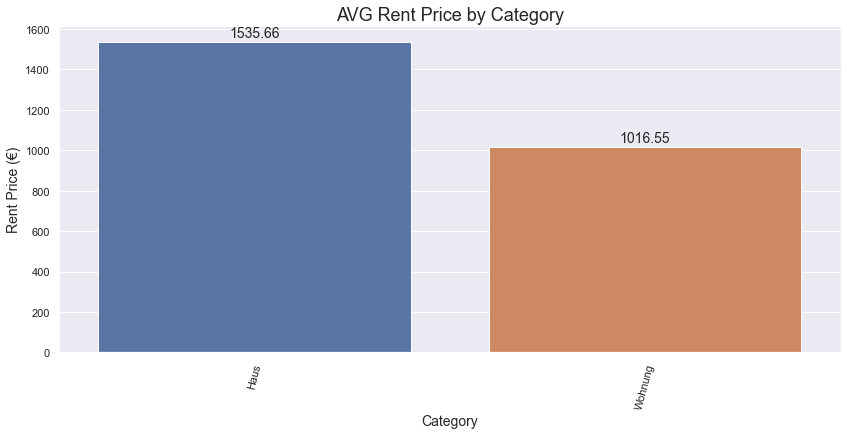

In [35]:
df_aux = pd.DataFrame(df2.groupby('main_category')['rent_price'].mean()).reset_index().sort_values(by='rent_price', ascending=False)
# plot the infos
ax = sns.barplot(x=df_aux['main_category'], y=df_aux['rent_price'])
plt.title('AVG Rent Price by Category', fontsize = 18)
plt.ylabel('Rent Price (€)', fontsize = 14)
plt.xlabel('Category', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax)
plt.savefig('../charts/avg_rent_price_by_categpory.png')

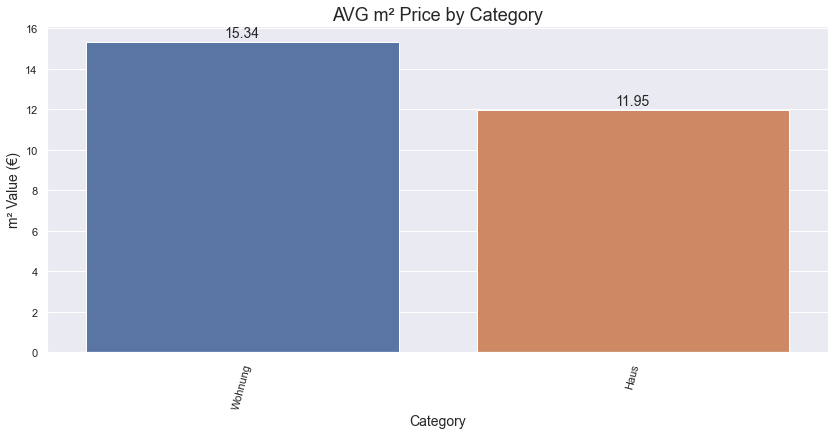

In [36]:
df_aux = pd.DataFrame(df2.groupby('main_category')['price_m2'].mean()).reset_index().sort_values(by='price_m2', ascending=False)
# plot the infos
ax = sns.barplot(x=df_aux['main_category'], y=df_aux['price_m2'])
plt.title('AVG m² Price by Category', fontsize = 18)
plt.ylabel('m² Value (€)', fontsize = 14)
plt.xlabel('Category', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax)
plt.savefig('../charts/avg_price_m2_by_categpory.png')

### Subcategory

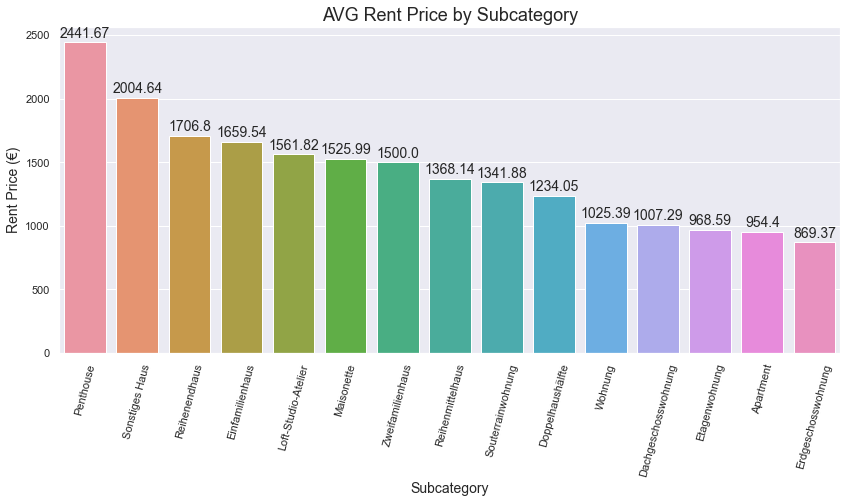

In [112]:
df_aux = pd.DataFrame(df2.groupby('sub_category')['rent_price'].mean()).reset_index().sort_values(by='rent_price', ascending=False)
# plot the infos
ax = sns.barplot(x=df_aux['sub_category'], y=df_aux['rent_price'])
plt.title('AVG Rent Price by Subcategory', fontsize = 18)
plt.ylabel('Rent Price (€)', fontsize = 14)
plt.xlabel('Subcategory', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax)
plt.savefig('../charts/avg_rent_price_by_subcategpory.png')

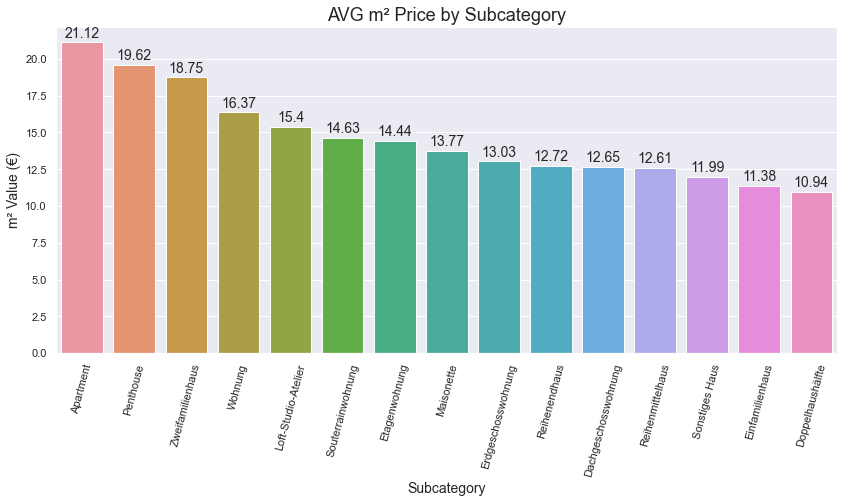

In [38]:
df_aux = pd.DataFrame(df2.groupby('sub_category')['price_m2'].mean()).reset_index().sort_values(by='price_m2', ascending=False)
# plot the infos
ax = sns.barplot(x=df_aux['sub_category'], y=df_aux['price_m2'])
plt.title('AVG m² Price by Subcategory', fontsize = 18)
plt.ylabel('m² Value (€)', fontsize = 14)
plt.xlabel('Subcategory', fontsize = 14)
plt.xticks(rotation=75)
annot_plot(ax)
plt.savefig('../charts/avg_price_m2_by_subcategpory.png')

### Balcony, Kirchen and Garden

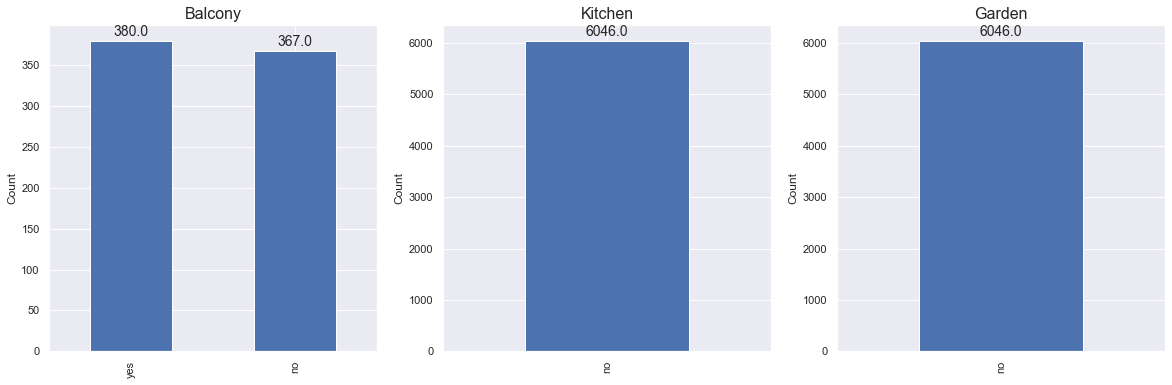

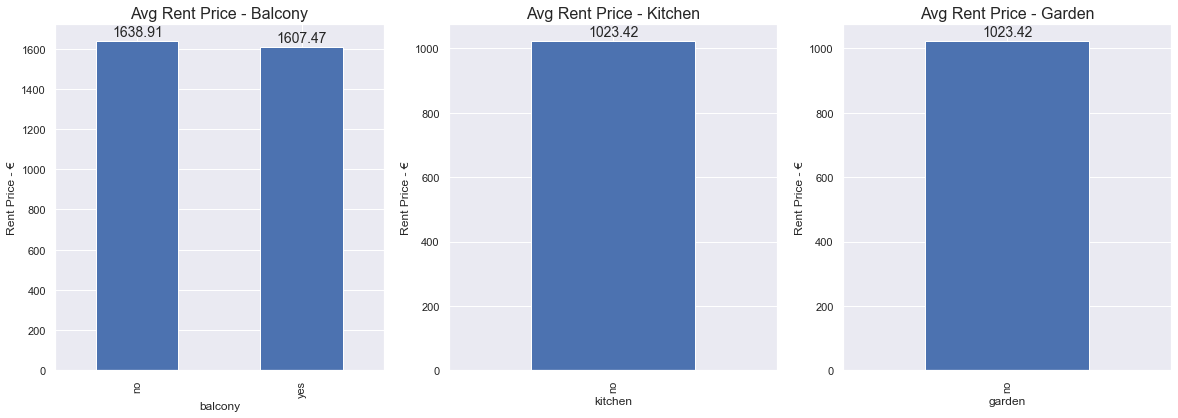

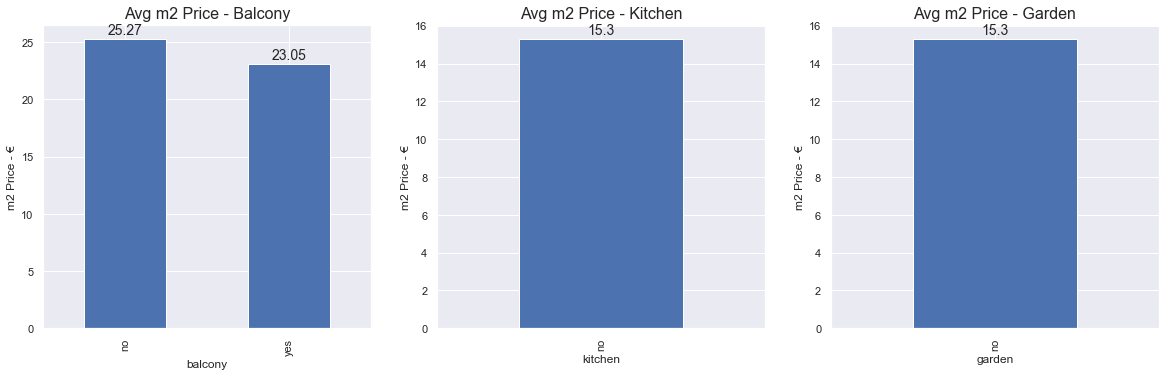

In [121]:
plt.figure(figsize=[20,6])
plt.subplot(1,3,1)
ax1 = df2['balcony'].value_counts().plot(kind='bar')
annot_plot(ax1)
plt.title(f'Balcony', fontsize=16)
plt.ylabel('Count')
plt.subplot(1,3,2)
ax2 = df2['kitchen'].value_counts().plot(kind='bar')
plt.title(f'Kitchen', fontsize=16)
plt.ylabel('Count')
annot_plot(ax2)
plt.subplot(1,3,3)
ax3 = df2['garden'].value_counts().plot(kind='bar')
plt.title(f'Garden', fontsize=16)
plt.ylabel('Count')
annot_plot(ax3)

plt.figure(figsize=[20,14])
plt.subplot(2,3,1)
ax4 = df2.groupby('balcony')['rent_price'].mean().plot(kind='bar')
annot_plot(ax4)
plt.title(f'Avg Rent Price - Balcony', fontsize=16)
plt.ylabel('Rent Price - €')
plt.subplot(2,3,2)
ax5 = df2.groupby('kitchen')['rent_price'].mean().plot(kind='bar')
plt.title(f'Avg Rent Price - Kitchen', fontsize=16)
plt.ylabel('Rent Price - €')
annot_plot(ax5)
plt.subplot(2,3,3)
ax6 = df2.groupby('garden')['rent_price'].mean().plot(kind='bar')
plt.title(f'Avg Rent Price - Garden', fontsize=16)
plt.ylabel('Rent Price - €')
annot_plot(ax6)

plt.figure(figsize=[20,19])
plt.subplot(3,3,1)
ax7 = df2.groupby('balcony')['price_m2'].mean().plot(kind='bar')
annot_plot(ax7)
plt.title(f'Avg m2 Price - Balcony', fontsize=16)
plt.ylabel('m2 Price - €')
plt.subplot(3,3,2)
ax8 = df2.groupby('kitchen')['price_m2'].mean().plot(kind='bar')
plt.title(f'Avg m2 Price - Kitchen', fontsize=16)
plt.ylabel('m2 Price - €')
annot_plot(ax8)
plt.subplot(3,3,3)
ax9 = df2.groupby('garden')['price_m2'].mean().plot(kind='bar')
plt.title(f'Avg m2 Price - Garden', fontsize=16)
plt.ylabel('m2 Price - €')
annot_plot(ax9)
plt.savefig(f'../charts/balc_kitc_gart.png');

### Number of Rooms

In [128]:
df2.head()

,extraction_date,offer_id,city,state,zip_code,lat,lng,main_category,sub_category,offer_title,rent_price,area_m2,price_m2,rooms,balcony,kitchen,garden,build_year,heat_type
0,2021-11-17 22:34:03,45678593,Dusseldorf,Hessen,60327.00000,50.10168,8.65827,Wohnung,Etagenwohnung,* frisch renovierte 3 Zimmerwohnung * Innensta...,790.00000,65.00000,12.15385,3.00000,NaN,no,no,1903.00000,Zentralheizung
1,2021-11-17 22:34:03,45907970,Dusseldorf,Nordrhein-Westfalen,50674.00000,50.92959,6.95620,Wohnung,Apartment,Apartment Wohnung voll möbliert inder Zentral...,600.00000,40.00000,15.00000,1.00000,NaN,no,no,1994.00000,Etagenheizung
2,2021-11-17 22:34:03,45809674,Dusseldorf,Nordrhein-Westfalen,44139.00000,51.51577,7.46851,Wohnung,Etagenwohnung,Erstbezug | Parkett | Gäste-WC| AR | 2 großräu...,1267.00000,93.92000,13.49020,3.00000,NaN,no,no,2021.00000,Zentralheizung
3,2021-11-17 22:34:03,44924940,Dusseldorf,Sachsen,1159.00000,51.04431,13.69902,Wohnung,Etagenwohnung,Frisch sanierte 2 Raum Wohnung in ruhiger Lage...,440.00000,55.00000,8.00000,2.00000,NaN,no,no,NaN,Zentralheizung
4,2021-11-17 22:34:03,44630030,Dusseldorf,Hessen,60314.00000,50.11131,8.70392,Wohnung,Wohnung,wunderschön möbilierte Wohnung gegenüber ECB,1299.00000,50.00000,25.98000,2.00000,NaN,no,no,1955.00000,Zentralheizung


In [ ]:
from collection import Counter

count = Counter(df2[''])

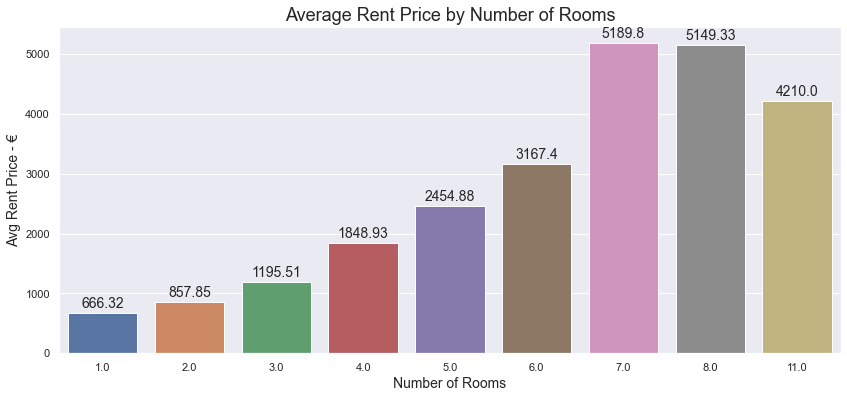

In [113]:
df_aux = pd.DataFrame(df2.groupby('rooms')['price_m2', 'rent_price'].mean()).reset_index()

ax = sns.barplot(x=df_aux['rooms'], y=df_aux['rent_price'])
plt.title('Average Rent Price by Number of Rooms', fontsize = 18)
plt.ylabel('Avg Rent Price - €', fontsize = 14)
plt.xlabel('Number of Rooms', fontsize = 14)
annot_plot(ax)
plt.savefig('../charts/avg_rent_price_num_rooms.png')

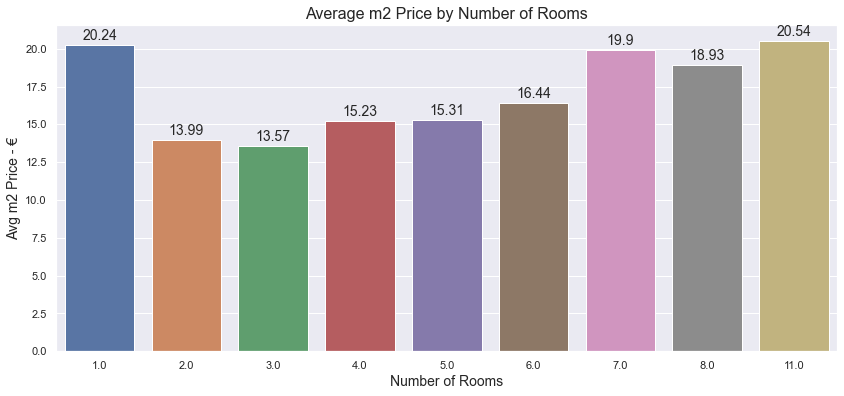

In [111]:
ax = sns.barplot(x=df_aux['rooms'], y=df_aux['price_m2'])
ax.set_title('Average m2 Price by Number of Rooms', fontsize=16)
ax.set_ylabel('Avg m2 Price - €', fontsize=14)
ax.set_xlabel('Number of Rooms', fontsize=14)
annot_plot(ax)
plt.savefig('../charts/avg_m2_price_num_rooms.png')

### Correlation

<AxesSubplot:>

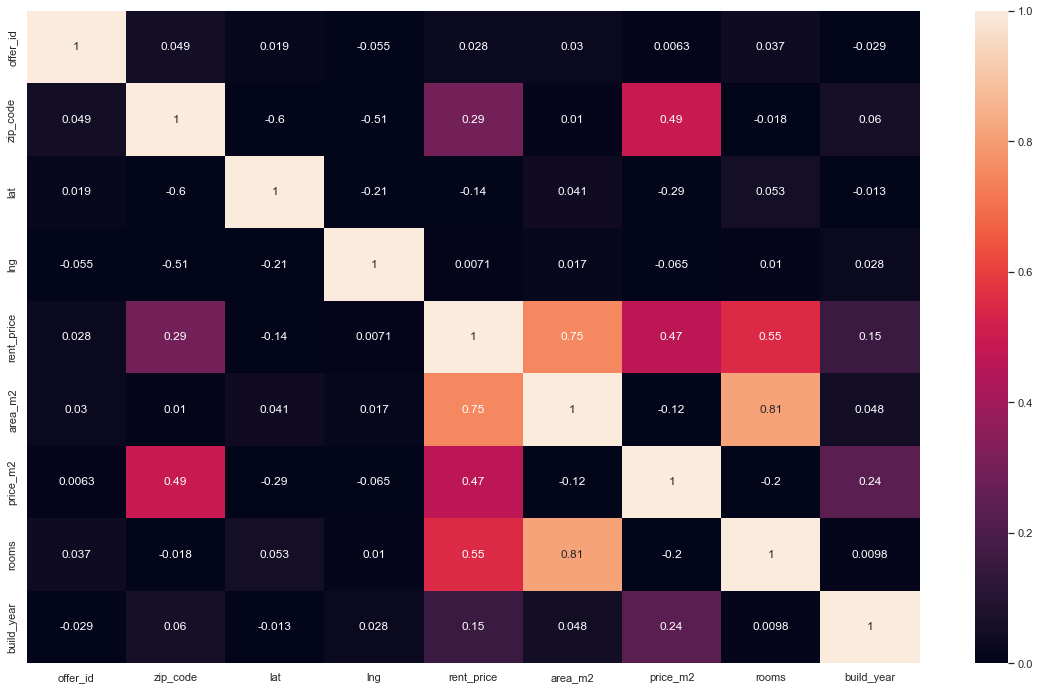

In [61]:
plt.figure(figsize=[20,12])
sns.heatmap(df2.corr(), vmin=0, vmax=1, annot=True)

## Offer Title Analysis

In [51]:
text = str(df2['offer_title'])

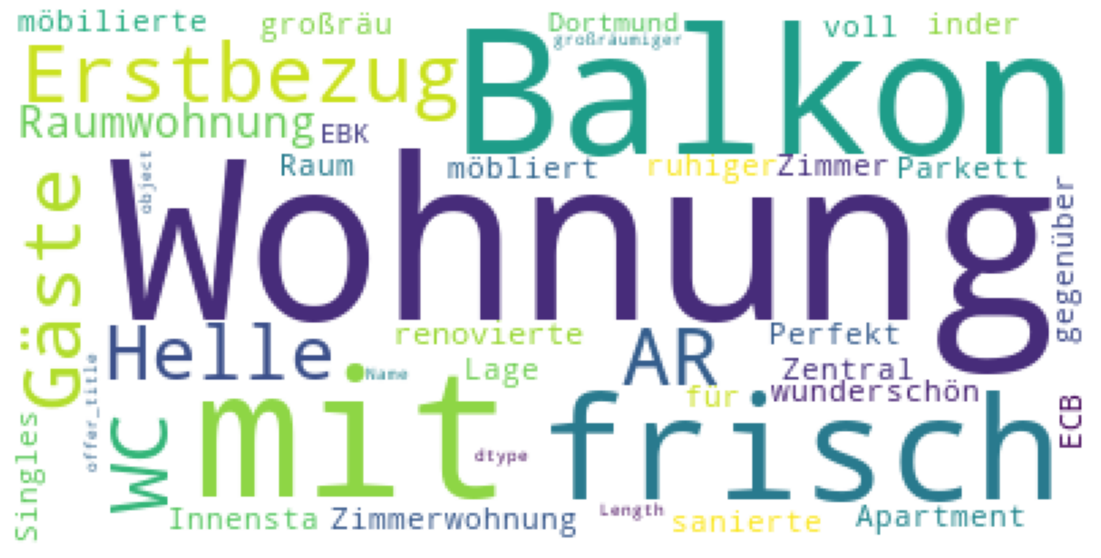

In [97]:
wordcloud = WordCloud(background_color="white").generate(text)
# Generate plot
plt.figure(figsize=[20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Hypothesis

**H1. Offers with larger areas are more expensive.**

As expected, this hypothesis is **FALSE**.

As we can see in the chart below, as the area size increases, the rent average price increses as well and this is natural, places with bigger areas should have a bigger cost.

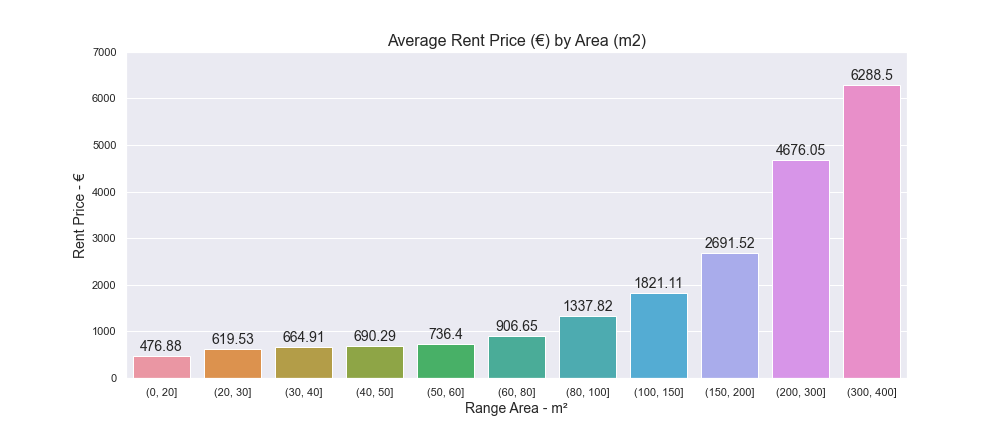

But when we analyze the average price per m2 for each range of area, the data shows us that not necessarily the bigger places are more expensive, they have a bigger cost, but the most expensive places are the smallest ones, they have a much bigger cost by m2 than the medium to bigger places.

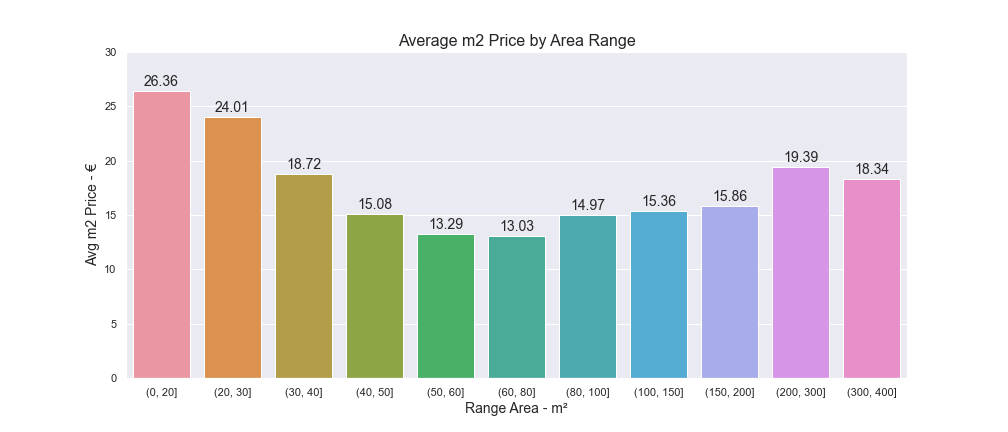

**H2. The more rooms, the more expensive.**

The situation here is similar than the previous and the hypotesys is aldo **FALSE**. 

When we analyze the rent cost and the number of rooms, is natural that as bigger the number of room, the bigger the rent cost and the next chart shows us this. 

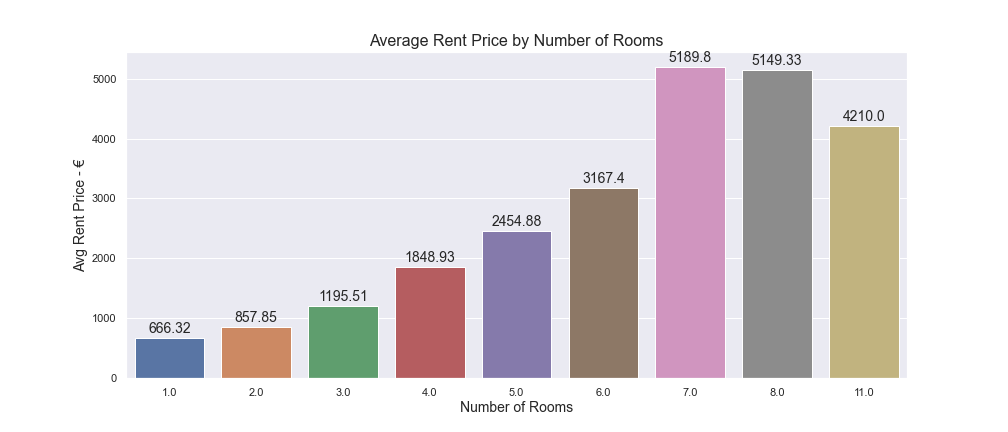

But again, when we analyze the m2 price by number of rooms, we can clearly see that the price per m2 is much bigger for places with less number of rooms, in other words, the relative cost is much bigger in smaller places or places with less number of rooms.

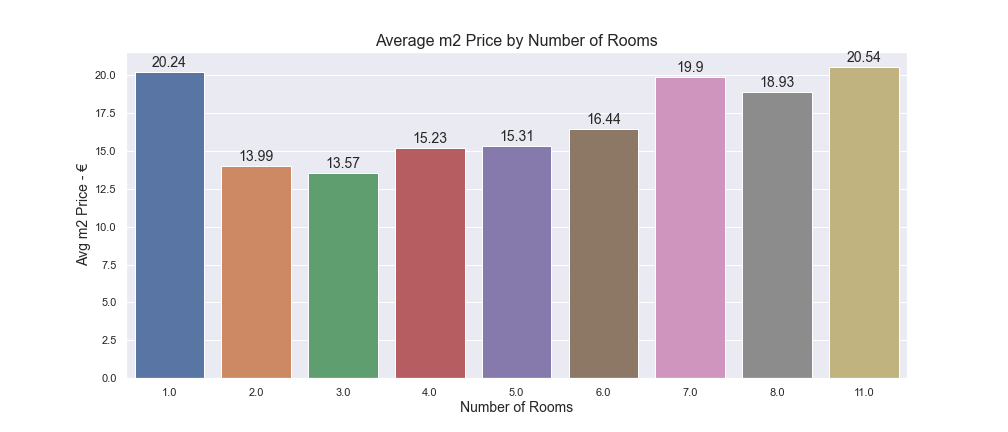





## Maps

In [ ]:
## PLOT SESSOES E PARAGENS

# coordenates matosinhos
lat = 51.1642292 
long = 10.4541194

# create map
de_map1 = folium.Map(location=[lat, long], zoom_start=7)

rainbow = ['red', 'blue', 'orange', 'green', 'darkblue', 'black']

# add markers
for lat, lon in zip(df1['lat'],
                    df1['lng']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        color = 'red',
        fill=True,
        fill_color= 'yellow',
        fill_opacity=0.4).add_to(de_map1)


de_map1

### Grouped offers with main infos

In [ ]:
germany = '../geo_data/germany_cities.geo.json'
geo_json_data = json.load(open(germany))

de_map2 = folium.Map(location = [lat, long], zoom_start = 6)

prices = plugins.MarkerCluster().add_to(de_map2)


for lat, lng, i in zip(df1['lat'], df1['lng'], list(range(df1.shape[0]))):
    label = f'{df1["main_category"].values[i]} - Price: €{df1["rent_price"].values[i]} - Area: {df1["area_m2"].values[i]}m2'
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        location = [lat, lng],
        icon = None,
        popup = label).add_to(prices)
    
folium.GeoJson(geo_json_data, style_function=lambda feature: {'color': 'darkred','weight': 0.5,}).add_to(de_map2)

de_map2